Some sources:

* Gensim LDA: https://radimrehurek.com/gensim/models/ldamodel.html
* Misc clustering with Python: http://brandonrose.org/clustering
* Scikit LDA: http://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html
* Scikit NMF: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* WMD in Python: http://vene.ro/blog/word-movers-distance-in-python.html
* Original WMD paper: http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf
* Scikit Affinity propagation: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html

# Greek (TLG)

In [1]:
import os
import time

In [2]:
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_index
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithets
from cltk.corpus.greek.tlg.parse_tlg_indices import select_authors_by_epithet
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_of_author
from cltk.corpus.greek.tlg.parse_tlg_indices import get_id_author
from cltk.stop.greek.stops import STOPS_LIST as greek_stops
from cltk.tokenize.word import nltk_tokenize_words

from greek_accentuation.characters import base

import pandas

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
def stream_lemmatized_files(corpus_dir):
    # return all docs in a dir
    user_dir = os.path.expanduser('~/cltk_data/user_data/' + corpus_dir)
    files = os.listdir(user_dir)

    for file in files:
        filepath = os.path.join(user_dir, file)
        with open(filepath) as fo:
            yield fo.read()

In [4]:
def map_file_order_to_name(corpus_dir):
    # read contents of dir, order and their tlg name
    user_dir = os.path.expanduser('~/cltk_data/user_data/' + corpus_dir)
    files = os.listdir(user_dir)
    
    map_id_author = get_id_author()  # {…, '1648': 'Pyrgion Hist.', '4017': 'Syrianus Phil.', …}

    map_count_name = {}
    for count, file in enumerate(files):
        file_id = str(file[3:-4])
        name = map_id_author[file_id]
        map_count_name[count] = name
    
    return map_count_name

In [5]:
map_file_count_name = map_file_order_to_name('tlg_lemmatized_no_accents_no_stops')

In [6]:
t0 = time.time()

data_samples = []
for text in stream_lemmatized_files('tlg_lemmatized_no_accents_no_stops'):
    data_samples.append(text)

print('Time to collect texts: {}'.format(time.time() - t0))
print('Number of texts:', len(data_samples))

Time to collect texts: 5.617557048797607
Number of texts: 1823


In [7]:
# view all epithets:
get_epithets()

['Alchemistae',
 'Apologetici',
 'Astrologici',
 'Astronomici',
 'Atticistae',
 'Biographi',
 'Bucolici',
 'Choliambographi',
 'Chronographi',
 'Comici',
 'Doxographi',
 'Elegiaci',
 'Epici/-ae',
 'Epigrammatici/-ae',
 'Epistolographi',
 'Geographi',
 'Geometri',
 'Gnomici',
 'Gnostici',
 'Grammatici',
 'Hagiographi',
 'Historici/-ae',
 'Hymnographi',
 'Iambici',
 'Lexicographi',
 'Lyrici/-ae',
 'Mathematici',
 'Mechanici',
 'Medici',
 'Mimographi',
 'Musici',
 'Mythographi',
 'Nomographi',
 'Onirocritici',
 'Oratores',
 'Paradoxographi',
 'Parodii',
 'Paroemiographi',
 'Periegetae',
 'Philologi',
 'Philosophici/-ae',
 'Poetae',
 'Poetae Didactici',
 'Poetae Medici',
 'Poetae Philosophi',
 'Polyhistorici',
 'Rhetorici',
 'Scriptores Ecclesiastici',
 'Scriptores Erotici',
 'Scriptores Fabularum',
 'Scriptores Rerum Naturalium',
 'Sophistae',
 'Tactici',
 'Theologici',
 'Tragici']

In [8]:
# tf-idf features
n_samples = 2000
n_features = 1000  # TODO: increase
n_topics = len(get_epithets())
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, 
                                   min_df=1,
                                   max_features=n_features,
                                   stop_words=None)
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print('Time to extract tf-idf features: {} secs.'.format(time.time() - t0))

Time to extract tf-idf features: 100.91713690757751 secs.


In [9]:
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time.time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print('Fit NMF model in {}'.format(time.time() - t0))

Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
Fit NMF model in 8.27451491355896


In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_id, topic in enumerate(model.components_):
        print('Topic #{}:'.format(int(topic_id)))
        print(''.join([feature_names[i] + ' ' + str(round(topic[i], 2))
              +' | ' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

In [11]:
print("Topics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics in NMF model:
Topic #0:
ειμι 2.55 | ου 2.46 | τος 1.31 | αυ 1.07 | εχω 0.97 | τας 0.68 | αλλ 0.52 | δεω1 0.43 | ποιεω 0.43 | εγω 0.42 | ωσπερ 0.42 | τουτων 0.41 | εαυτου 0.39 | πα 0.37 | οσος 0.33 | καθ 0.33 | ευ 0.33 | ος 0.33 | ουδεν 0.32 | δι 0.31 | 

Topic #1:
αυ 3.52 | τος 3.44 | αυτον 0.79 | αυτους 0.32 | αυτην 0.28 | τας 0.24 | τοτε 0.17 | εγενετο 0.15 | εαυτου 0.15 | εκει 0.15 | πολιν 0.15 | υπ 0.14 | μετ 0.14 | πολεως 0.14 | τουτου 0.13 | ηως 0.13 | αδελφος 0.13 | πολυς 0.13 | ερχομαι 0.13 | γυνη 0.12 | 

Topic #2:
εγω 4.05 | εμεω 0.24 | σε 0.23 | εμοι 0.17 | ειδον 0.16 | εμε 0.15 | συ 0.14 | παρ 0.14 | νυ 0.13 | οπως 0.12 | ταυτ 0.12 | οιδα 0.11 | ερχομαι 0.1 | πως 0.09 | ουδ 0.09 | σευω 0.09 | ποθεν 0.09 | ειπε 0.09 | καγω 0.09 | χρηματα 0.08 | 

Topic #3:
φημι 3.37 | αυτον 0.42 | ειμι 0.35 | φησι 0.24 | γενεσθαι 0.23 | λεγει 0.23 | φασι 0.21 | ιστορεω 0.19 | καθα 0.19 | φησιν 0.17 | καλεω 0.17 | αθηνη 0.16 | υστερος 0.16 | ποτε 0.15 | ομηρος 0.15 | ον 0.14 | λεγεται 

In [12]:
tfidf.shape

(1823, 1000)

In [13]:
doc_topic_distrib = nmf.transform(tfidf)  # numpy.ndarray

In [14]:
doc_topic_distrib.shape

(1823, 55)

In [15]:
df = pandas.DataFrame(doc_topic_distrib)

In [16]:
df = df.rename(map_file_count_name)

Questions:

* to what topic does each author most belong? (and how to determine cutoff?)
* what authors most exemplify a topic?

In [17]:
df

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Apollonius Rhodius Epic.,0.008242,0.036524,0.031082,0.007385,0.030441,0.276695,0.000000,0.035696,0.000000,0.022861,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027332,0.000000,0.000000,0.016152,0.000000
Theognis Eleg.,0.047067,0.000000,0.046855,0.000000,0.051642,0.134257,0.054331,0.023679,0.000000,0.000000,...,0.000000,0.008999,0.003188,0.000000,0.000000,0.013205,0.000000,0.000000,0.000000,0.000000
Thucydides Hist.,0.101537,0.065956,0.011589,0.000000,0.022067,0.021074,0.001556,0.017924,0.001924,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.006843,0.000000,0.000000,0.000000,0.000000
Diogenes Laertius Biogr.,0.113660,0.046509,0.007916,0.074166,0.002784,0.000000,0.000000,0.033737,0.000000,0.006540,...,0.000000,0.002134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Theocritus Bucol.,0.054391,0.015502,0.067163,0.000000,0.027391,0.166300,0.020212,0.033731,0.000000,0.000000,...,0.000000,0.000000,0.008156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Euripides Trag.,0.064044,0.000000,0.061053,0.000000,0.056361,0.095156,0.026170,0.049990,0.002007,0.000000,...,0.000000,0.000000,0.005795,0.000000,0.000000,0.010141,0.000000,0.000000,0.000000,0.000000
Plutarchus Biogr. et Phil.,0.158096,0.029795,0.001092,0.015922,0.019112,0.014260,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Athenaeus Soph.,0.123865,0.029537,0.014366,0.080690,0.009208,0.023742,0.018648,0.020011,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sappho Lyr.,0.024411,0.000000,0.108845,0.001343,0.033773,0.122476,0.024436,0.024487,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010710,0.000000,0.000000,0.000000,0.000000
Isocrates Orat.,0.129990,0.033435,0.042834,0.000000,0.014657,0.000000,0.012045,0.000000,0.001898,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.017119,0.000000,0.000000,0.000000,0.000000


In [18]:
# for each topic (col), which author (row) has the highest value?
# TODO: get top 5 authors

for count in range(n_topics):
    print('Top author of topic {0}: {1}'.format(count, df[count].idxmax()))

Top author of topic 0: Joannes Rhet.
Top author of topic 1: Cephalion Hist. et Rhet.
Top author of topic 2: Pamphilus Poeta
Top author of topic 3: Heraclides Phil.
Top author of topic 4: Eubulides Comic.
Top author of topic 5: Quintus Epic.
Top author of topic 6: Stratonicus Poeta
Top author of topic 7: Xenocles Trag.
Top author of topic 8: Capito Hist.
Top author of topic 9: Dionysius Thrax Gramm.
Top author of topic 10: Lexica Syntactica
Top author of topic 11: Melanthius Trag.
Top author of topic 12: Canon Librorum
Top author of topic 13: Euclides Geom.
Top author of topic 14: Chronographiae Anonymae
Top author of topic 15: Diogenes Phil.
Top author of topic 16: Moeris Attic.
Top author of topic 17: Mace(donius) Lyr.
Top author of topic 18: Autocrates Hist.
Top author of topic 19: [Alexarchus] Hist.
Top author of topic 20: Demetrius Comic.
Top author of topic 21: Choerilus Trag.
Top author of topic 22: Fragmentum Stoicum
Top author of topic 23: Acta Phileae
Top author of topic 24: L

In [19]:
# Now, transpose df and get top topic of each author
# for each topic (col), which author (row) has the highest value?
# TODO: get top 5 authors
df_t = df.T

In [20]:
df_t

,Apollonius Rhodius Epic.,Theognis Eleg.,Thucydides Hist.,Diogenes Laertius Biogr.,Theocritus Bucol.,Euripides Trag.,Plutarchus Biogr. et Phil.,Athenaeus Soph.,Sappho Lyr.,Isocrates Orat.,...,Macarius Chrysocephalus Paroemiogr.,Michael Apostolius Paroemiogr.,"Suda, Suidas",Ignatius Biogr. et Poeta,Arsenius Paroemiogr.,Stephanus Phil.,Stephanus Gramm.,Stephanus Alchem.,Joannes Tzetzes Gramm. et Poeta,Thomas Magister Philol.
0,0.008242,0.047067,0.101537,0.113660,0.054391,0.064044,0.158096,0.123865,0.024411,0.129990,...,0.113071,0.136326,0.119459,0.079524,0.129651,0.091940,0.133484,0.088006,0.106135,0.105958
1,0.036524,0.000000,0.065956,0.046509,0.015502,0.000000,0.029795,0.029537,0.000000,0.033435,...,0.000000,0.041658,0.041848,0.064819,0.000000,0.000000,0.021613,0.058973,0.037904,0.014897
2,0.031082,0.046855,0.011589,0.007916,0.067163,0.061053,0.001092,0.014366,0.108845,0.042834,...,0.000000,0.000000,0.003493,0.016902,0.009843,0.000000,0.007494,0.008364,0.035237,0.009422
3,0.007385,0.000000,0.000000,0.074166,0.000000,0.000000,0.015922,0.080690,0.001343,0.000000,...,0.000000,0.014324,0.013797,0.000000,0.000000,0.000000,0.000000,0.000000,0.027534,0.000000
4,0.030441,0.051642,0.022067,0.002784,0.027391,0.056361,0.019112,0.009208,0.033773,0.014657,...,0.022974,0.019184,0.002021,0.041783,0.029201,0.055901,0.025907,0.000000,0.000000,0.067595
5,0.276695,0.134257,0.021074,0.000000,0.166300,0.095156,0.014260,0.023742,0.122476,0.000000,...,0.042272,0.030915,0.033264,0.006469,0.058484,0.000000,0.000000,0.000000,0.010836,0.000388
6,0.000000,0.054331,0.001556,0.000000,0.020212,0.026170,0.000000,0.018648,0.024436,0.012045,...,0.006544,0.010691,0.004577,0.000000,0.007182,0.002109,0.002197,0.008066,0.011759,0.004061
7,0.035696,0.023679,0.017924,0.033737,0.033731,0.049990,0.000000,0.020011,0.024487,0.000000,...,0.000000,0.011124,0.021885,0.000000,0.020511,0.065010,0.019407,0.025494,0.012284,0.000000
8,0.000000,0.000000,0.001924,0.000000,0.000000,0.002007,0.000000,0.000000,0.000000,0.001898,...,0.000000,0.000604,0.011667,0.000000,0.000000,0.000000,0.000000,0.000000,0.001467,0.000000
9,0.022861,0.000000,0.000000,0.006540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008514,0.000000,0.000000,0.039004,0.041932,0.000000,0.000000,0.028477


In [34]:
map_name_epithet_id = {}
for curr_name in df_t.columns:
    print(curr_name)
    try:
        top_topic = int(df_t[curr_name].idxmax())
    except TypeError:  # there are some dupelicate names, just take one value for now
        top_topic = int(df_t[curr_name].idxmax().iloc[0])    
    print('    NMF topic:', top_topic)
    for _id, name in get_id_author().items():
        if curr_name == name:
            epithet = get_epithet_of_author(_id)
            print('    Traditional epithet:', epithet)
            map_name_epithet_id[name] = {'id': _id,
                                        'top_topic': top_topic,
                                        'epithet': epithet}
    print()

Apollonius Rhodius Epic.
    NMF topic: 5
    Traditional epithet: Epici/-ae

Theognis Eleg.
    NMF topic: 5
    Traditional epithet: Elegiaci

Thucydides Hist.
    NMF topic: 0
    Traditional epithet: Historici/-ae

Diogenes Laertius Biogr.
    NMF topic: 12
    Traditional epithet: Biographi

Theocritus Bucol.
    NMF topic: 5
    Traditional epithet: Bucolici

Euripides Trag.
    NMF topic: 5
    Traditional epithet: Tragici

Plutarchus Biogr. et Phil.
    NMF topic: 0
    Traditional epithet: Philosophici/-ae

Athenaeus Soph.
    NMF topic: 0
    Traditional epithet: Sophistae

Sappho Lyr.
    NMF topic: 30
    Traditional epithet: Lyrici/-ae

Isocrates Orat.
    NMF topic: 0
    Traditional epithet: Oratores

Sophocles Trag.
    NMF topic: 5
    Traditional epithet: Tragici

Homerus Epic., Homer
    NMF topic: 5
    Traditional epithet: Epici/-ae

Hymni Homerici, Homeric Hymns
    NMF topic: 5
    Traditional epithet: None

Demosthenes Orat.
    NMF topic: 0
    Traditional epit

Now let's look at the variations of the respective clusters, nmf topic and epithets

* Question: Which topics are found within each epithet?
* Question: Which epithets are found within each topic? And how many?

In [35]:
map_name_epithet_id['Silenus Trag.']

{'epithet': 'Tragici', 'id': '0603', 'top_topic': 0}

In [36]:
# Group by epithet, collect topics
# {<epithet>: [<topics>]}
from collections import defaultdict

map_epithet_topics = defaultdict(list)
for name, _dict in map_name_epithet_id.items():
    epithet = _dict['epithet']
    top_topic = _dict['top_topic']
    map_epithet_topics[epithet].append(top_topic)

In [42]:
# import pprint
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(dict(map_epithet_topics))
print(dict(map_epithet_topics))

{'Epistolographi': [0, 53, 0, 2, 49, 0, 13, 19, 10, 0], 'Gnomici': [5, 46, 6, 5], 'Theologici': [49, 49, 49, 49, 49, 49, 0, 0, 49, 49, 0, 49, 49, 49, 1, 49, 49, 49, 0, 0, 0, 49, 49, 49, 49, 49, 49, 0, 49, 0, 49, 49], 'Atticistae': [16, 0, 24, 24], 'Hymnographi': [49], 'Paroemiographi': [0, 0, 0, 0, 0], 'Geographi': [29, 6, 8, 8, 49, 0, 25, 8, 8, 0, 25, 0], 'Comici': [5, 7, 0, 4, 0, 34, 0, 22, 17, 0, 11, 6, 0, 31, 9, 32, 0, 0, 42, 31, 0, 50, 20, 10, 47, 35, 1, 0, 0, 7, 5, 15, 5, 6, 10, 40, 10, 0, 0, 0, 26, 5, 0, 50, 4, 2, 0, 1, 7, 0, 32, 2, 20, 0, 20, 2, 10, 0, 0, 0, 7, 10, 20, 0, 11, 40, 50, 50, 7, 0, 0, 2, 6, 1, 36, 0, 6, 50, 14, 4, 0, 29, 34, 35, 0, 20, 0, 0, 31, 0, 0, 4, 7, 2, 40, 42, 0, 17, 6, 38, 0, 0, 0, 32, 0, 15, 4, 6, 2, 29, 15, 2, 31, 33, 0, 2, 0, 32, 38, 27, 0, 36, 7, 2, 10, 32, 0, 0, 20, 41, 50, 44, 0, 27, 0, 0, 0, 2, 21, 31, 0, 50, 0, 36, 0, 0, 13, 0, 33], 'Scriptores Erotici': [0, 0, 0, 28, 0, 0, 0, 28], 'Mathematici': [12, 12, 13, 0, 15, 22, 13, 13, 13, 13, 0], 'Astronom

In [50]:
# which epithet has the most topics associated with it?
map_epithet_count_topics = {}
for epithet, topic_list in map_epithet_topics.items():
    map_epithet_count_topics[epithet] = len(topic_list)

sorted(map_epithet_count_topics.items(), key=lambda x:x[1], reverse=True)

[(None, 334),
 ('Historici/-ae', 309),
 ('Philosophici/-ae', 208),
 ('Comici', 149),
 ('Tragici', 80),
 ('Grammatici', 70),
 ('Epici/-ae', 57),
 ('Lyrici/-ae', 53),
 ('Scriptores Ecclesiastici', 48),
 ('Medici', 43),
 ('Sophistae', 41),
 ('Rhetorici', 39),
 ('Theologici', 32),
 ('Elegiaci', 29),
 ('Poetae', 29),
 ('Alchemistae', 22),
 ('Epigrammatici/-ae', 22),
 ('Astronomici', 13),
 ('Iambici', 13),
 ('Geographi', 12),
 ('Oratores', 11),
 ('Mathematici', 11),
 ('Epistolographi', 10),
 ('Astrologici', 10),
 ('Periegetae', 9),
 ('Paradoxographi', 9),
 ('Apologetici', 9),
 ('Scriptores Erotici', 8),
 ('Poetae Philosophi', 8),
 ('Mechanici', 7),
 ('Biographi', 7),
 ('Mythographi', 6),
 ('Philologi', 6),
 ('Tactici', 6),
 ('Chronographi', 6),
 ('Paroemiographi', 5),
 ('Parodii', 5),
 ('Gnomici', 4),
 ('Atticistae', 4),
 ('Musici', 4),
 ('Poetae Medici', 4),
 ('Geometri', 4),
 ('Lexicographi', 3),
 ('Bucolici', 3),
 ('Mimographi', 2),
 ('Gnostici', 2),
 ('Doxographi', 2),
 ('Scriptores Fabu

In [51]:
# Group by topic, collect epithets
# {<topic>: [<epithets>]}
from collections import defaultdict

map_topic_epithets = defaultdict(list)
for name, _dict in map_name_epithet_id.items():
    epithet = _dict['epithet']
    top_topic = _dict['top_topic']
    map_topic_epithets[top_topic].append(epithet)

In [53]:
dict(map_topic_epithets)

{0: ['Historici/-ae',
  'Philosophici/-ae',
  'Sophistae',
  'Poetae',
  'Sophistae',
  'Tragici',
  'Paroemiographi',
  'Comici',
  'Sophistae',
  'Comici',
  'Scriptores Fabularum',
  'Philosophici/-ae',
  'Sophistae',
  'Sophistae',
  'Philosophici/-ae',
  'Comici',
  'Sophistae',
  'Alchemistae',
  None,
  'Philosophici/-ae',
  'Poetae',
  'Tragici',
  'Comici',
  None,
  'Oratores',
  'Historici/-ae',
  'Medici',
  'Biographi',
  None,
  'Comici',
  'Rhetorici',
  'Historici/-ae',
  None,
  'Historici/-ae',
  None,
  'Rhetorici',
  None,
  'Oratores',
  'Medici',
  'Philosophici/-ae',
  'Grammatici',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Comici',
  'Medici',
  None,
  'Apologetici',
  'Tactici',
  'Comici',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Medici',
  'Tragici',
  'Lyrici/-ae',
  'Paradoxographi',
  'Musici',
  None,
  'Scriptores Ecclesiastici',
  'Astronomici',
  'Sophistae',
  'Paroemiographi',
  'Philosophici/-ae',
  'Comici',
  'Phi

In [58]:
# which epithet has the most topics associated with it?
map_topics_count_epithet = {}
for topic, epithet_list in map_topic_epithets.items():
    map_topics_count_epithet[topic] = len(epithet_list)

# map_topics_count_epithet
sorted(map_topics_count_epithet.items(), key=lambda x:x[1], reverse=True)

[(0, 506),
 (49, 106),
 (5, 101),
 (1, 95),
 (2, 44),
 (3, 42),
 (19, 39),
 (8, 38),
 (10, 37),
 (46, 33),
 (12, 32),
 (24, 32),
 (44, 32),
 (7, 29),
 (4, 27),
 (6, 26),
 (13, 25),
 (18, 24),
 (37, 21),
 (14, 20),
 (29, 20),
 (31, 20),
 (21, 19),
 (45, 19),
 (30, 18),
 (51, 18),
 (36, 17),
 (9, 16),
 (20, 16),
 (22, 16),
 (11, 15),
 (15, 15),
 (23, 15),
 (38, 15),
 (48, 15),
 (50, 15),
 (17, 14),
 (27, 14),
 (33, 14),
 (52, 13),
 (41, 12),
 (25, 11),
 (28, 11),
 (39, 11),
 (54, 11),
 (26, 10),
 (34, 10),
 (35, 10),
 (40, 10),
 (42, 10),
 (43, 10),
 (47, 10),
 (32, 8),
 (53, 6),
 (16, 5)]

In [59]:
# also do this all w/ countvectorizer?

In [60]:
# http://scikit-learn.org/stable/modules/clustering.html

In [61]:
dataset_array = df.values
print(dataset_array.dtype)  # kmeans needs to be homogeneous data type (here, float64)
print(dataset_array)

float64
[[ 0.00824198  0.03652398  0.03108222 ...,  0.          0.01615235  0.        ]
 [ 0.04706742  0.          0.04685514 ...,  0.          0.          0.        ]
 [ 0.10153668  0.06595567  0.0115893  ...,  0.          0.          0.        ]
 ..., 
 [ 0.0880064   0.05897268  0.00836376 ...,  0.          0.          0.        ]
 [ 0.10613521  0.03790386  0.03523662 ...,  0.          0.          0.        ]
 [ 0.10595783  0.01489671  0.00942192 ...,  0.          0.          0.        ]]


In [62]:
# do I need to normalize
# sklearn.preprocessing.StandardScaler
from sklearn import preprocessing

In [63]:
# http://scikit-learn.org/stable/modules/preprocessing.html
# first load scaler and train on given data set
scaler = preprocessing.StandardScaler().fit(df)

In [64]:
scaler.mean_

array([ 0.05019921,  0.0255092 ,  0.01397297,  0.01327393,  0.01495358,
        0.01682819,  0.0106435 ,  0.01827097,  0.00683908,  0.00642039,
        0.01236455,  0.0085962 ,  0.00649821,  0.00558679,  0.00432717,
        0.00722202,  0.00215602,  0.00646187,  0.0057925 ,  0.00758634,
        0.00484418,  0.00656875,  0.00489019,  0.00575802,  0.00585413,
        0.00415333,  0.00372114,  0.0057934 ,  0.00227336,  0.0064333 ,
        0.00536679,  0.00394071,  0.0054923 ,  0.00498952,  0.00439297,
        0.00433457,  0.00455127,  0.00448185,  0.00398487,  0.0028697 ,
        0.00211415,  0.00439907,  0.00478673,  0.0031645 ,  0.00697561,
        0.0043648 ,  0.00606566,  0.00472907,  0.00291753,  0.01367439,
        0.00459177,  0.00421821,  0.00297059,  0.00310003,  0.00268476])

In [65]:
scaler.scale_

array([ 0.04603533,  0.03202729,  0.02586347,  0.02606835,  0.02198726,
        0.03800937,  0.02016901,  0.02141974,  0.03082646,  0.02172892,
        0.02452027,  0.01946246,  0.02956141,  0.03384907,  0.02631689,
        0.02008212,  0.02062244,  0.0179572 ,  0.02298408,  0.0250701 ,
        0.01600548,  0.01951937,  0.01934805,  0.02031044,  0.02704938,
        0.02358621,  0.01857639,  0.0184143 ,  0.02217991,  0.01903844,
        0.02314547,  0.01732269,  0.01553694,  0.0171219 ,  0.01732228,
        0.01877199,  0.01768333,  0.02566982,  0.02052266,  0.02259618,
        0.027696  ,  0.02023981,  0.01819136,  0.01867748,  0.02453883,
        0.02552122,  0.02422061,  0.01545062,  0.02224687,  0.03765047,
        0.01538947,  0.01859583,  0.02432938,  0.01869078,  0.02077123])

In [66]:
# actually do normalization; can be reused for eg a training set
df_scaled = pandas.DataFrame(scaler.transform(df))

In [67]:
from sklearn import cluster

In [95]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix = df_scaled.as_matrix()

km = cluster.KMeans(n_clusters=n_topics)
km.fit(matrix)

# Get cluster assignment labels
labels = km.labels_  # these are the topics 0-54; array([53, 53, 16, ..., 42, 16, 13]

# Format results as a DataFrame
df_clusters = pandas.DataFrame([df_scaled.index, labels]).T  # add author names to the 0 col

In [100]:
df_clusters.head(5)

,0,1
0,0,3
1,1,3
2,2,18
3,3,16
4,4,3


In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# from pandas.tools.plotting import table

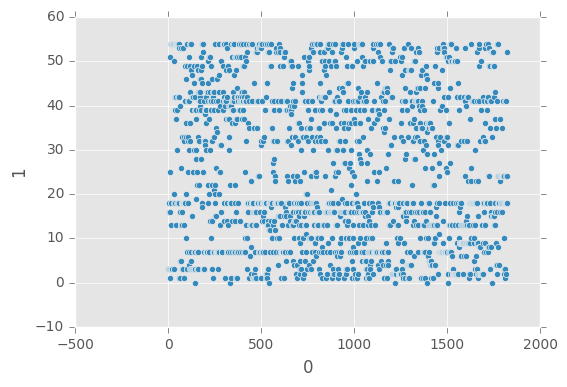

In [98]:
plt.figure()
df_clusters.plot.scatter(x=0, y=1)  # y is topics no., x is doc id

## Kmeans based tfidf matrix

In [107]:
# try clustering the original tfidf
# tfidf_dense = tfidf.toarray()
scaler = preprocessing.StandardScaler().fit(tfidf) # either with_mean=False or make dense

In [109]:
df_scaled_tfidf = pandas.DataFrame(scaler.transform(tfidf))

In [118]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix_tfidf = df_scaled_tfidf.as_matrix()

km_tfidf = cluster.KMeans(n_clusters=n_topics)
km_tfidf.fit(matrix_tfidf)

# Get cluster assignment labels
labels = km_tfidf.labels_  # these are the topics 0-54; array([53, 53, 16, ..., 42, 16, 13]

# Format results as a DataFrame
df_clusters_tfidf = pandas.DataFrame([df_scaled_tfidf.index, labels]).T  # add author names to the 0 col

In [119]:
df_clusters_tfidf.head(5)

,0,1
0,0,52
1,1,52
2,2,28
3,3,33
4,4,52


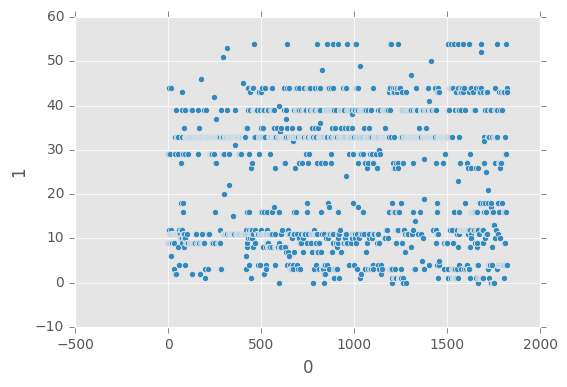

In [117]:
plt.figure()
df_clusters_tfidf.plot.scatter(x=0, y=1)  # y is topics no., x is doc id

## Kmeans based on nmf

In [127]:
nmf_array = nmf.components_

In [128]:
# nmf_dense = nmf_array.toarray()
scaler = preprocessing.StandardScaler().fit(nmf_array) # either with_mean=False or make dense

In [129]:
df_scaled_nmf = pandas.DataFrame(scaler.transform(nmf_array))

In [130]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix_nmf = df_scaled_nmf.as_matrix()

km_nmf = cluster.KMeans(n_clusters=n_topics)
km_nmf.fit(matrix_nmf)

# Get cluster assignment labels
labels = km_nmf.labels_  # these are the clusters 0-54; array([ 1,  4, 11, 14, 28,  9, 30,

# Format results as a DataFrame
df_clusters_nmf = pandas.DataFrame([df_scaled_nmf.index, labels]).T  # add author names to the 0 col

In [134]:
df_clusters_nmf

,0,1
0,0,1
1,1,4
2,2,11
3,3,14
4,4,28
5,5,9
6,6,30
7,7,26
8,8,8
9,9,18


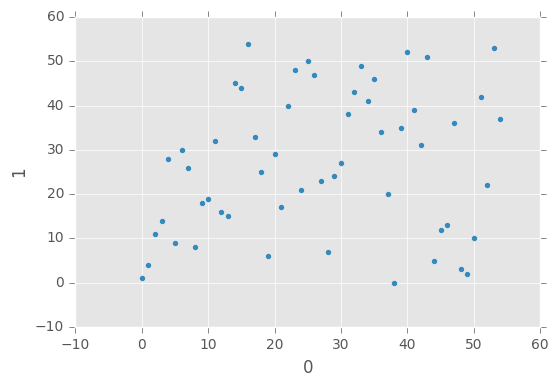

In [132]:
plt.figure()
df_clusters_nmf.plot.scatter(x=0, y=1)  # y is topics no., x is doc id